In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
image_size = (256,256)
batch_size = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    shuffle=True,
    image_size = image_size,
    batch_size = 32
                      )

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

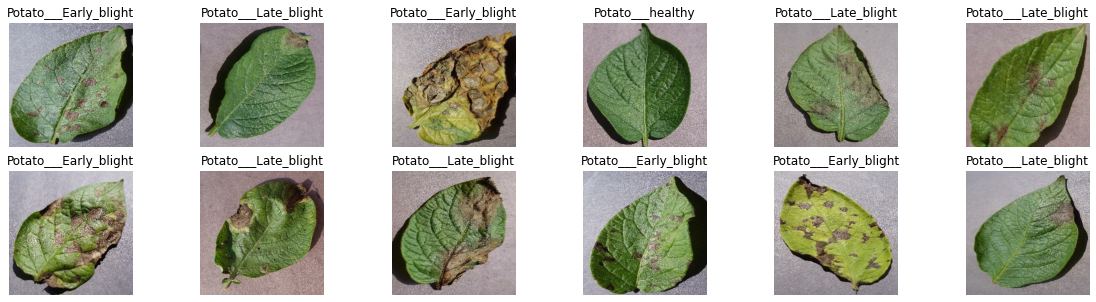

In [6]:
plt.figure(figsize=(20,5))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(2,6,i+1)
        #print(label_batch[i])
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")

In [7]:
def partition_dataset(ds,train_size = 0.8, test_size = 0.1, val_size = 0.1,shuffle=True,shuffle_size = 1000,seed = 1):
    if shuffle:
        ds = ds.shuffle(shuffle_size)
    total_data = len(ds)
    train_len = int(train_size*total_data)
    train_data = ds.take(train_len)
    test_len = int(test_size*total_data)
    test_data = ds.skip(train_len).take(test_len)
    val_data = ds.skip(train_len).skip(test_len)
    return train_data, test_data, val_data
    

In [8]:
train,test,val = partition_dataset(dataset)
len(train)

54

In [9]:
train = train.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(image_size[0],image_size[1]),
        layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3)
])

In [12]:
train = train.map(
    lambda x,y: (augmentation(x, training = True),y)
).prefetch(tf.data.AUTOTUNE)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [14]:
IMG_SHAPE = image_size + (3,)
n_classes = len(class_names)

In [15]:
base_model = tf.keras.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape = IMG_SHAPE),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten()
])

In [16]:
prediction_layer = layers.Dense(n_classes, activation='softmax')

In [17]:
model = models.Sequential([
    resize_and_rescale,
    base_model,
    prediction_layer  
])

In [18]:
model.compile(
            optimizer = 'adam',
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
            metrics = ['accuracy']
             )

In [19]:
model.build(input_shape = ((batch_size,)+IMG_SHAPE) )

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 2304)              130176    
_________________________________________________________________
dense (Dense)                (32, 3)                   6915      
Total params: 137,091
Trainable params: 137,091
Non-trainable params: 0
_________________________________________________________________


In [21]:
earlystopping = EarlyStopping(monitor='val_loss',
                             patience = 9,
                             restore_best_weights = True)

reducelr = ReduceLROnPlateau(monitor = 'val_loss',
                             factor = 0.1,
                             patience = 5,
                             min_lr = 0.000001
                            )

In [22]:
EPOCHS = 50

In [23]:
history = model.fit(
    train,
    epochs = EPOCHS,
    validation_data = val,
    callbacks = [earlystopping,reducelr]

)

Epoch 1/50
54/54 [==============================] - 36s 437ms/step - loss: 0.8028 - accuracy: 0.6004 - val_loss: 0.5389 - val_accuracy: 0.7930
Epoch 2/50
54/54 [==============================] - 15s 272ms/step - loss: 0.4429 - accuracy: 0.8151 - val_loss: 0.4543 - val_accuracy: 0.8125
Epoch 3/50
54/54 [==============================] - 14s 261ms/step - loss: 0.3071 - accuracy: 0.8756 - val_loss: 0.4126 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 14s 261ms/step - loss: 0.2621 - accuracy: 0.8985 - val_loss: 0.2274 - val_accuracy: 0.9023
Epoch 5/50
54/54 [==============================] - 14s 261ms/step - loss: 0.2079 - accuracy: 0.9202 - val_loss: 0.2052 - val_accuracy: 0.9102
Epoch 6/50
54/54 [==============================] - 14s 260ms/step - loss: 0.2000 - accuracy: 0.9261 - val_loss: 0.2305 - val_accuracy: 0.8984
Epoch 7/50
54/54 [==============================] - 14s 262ms/step - loss: 0.1793 - accuracy: 0.9325 - val_loss: 0.2191 - val_accuracy: 0.9219

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1207609453516573912
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2291870460711836435
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [25]:
scores =  model.evaluate(test)

6/6 [==============================] - 3s 35ms/step - loss: 0.1134 - accuracy: 0.9531


In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [28]:
model.save("models/potatoes2.h5")